# Stochastic Diffusion-Limited Aggregation (DLA) Model

In a typical DLA, particles (or walkers) perform a random walk until they come into contact with the aggregate. In our stochastic version, even when a walker comes into contact, it might not always stick, based on a stochastic acceptance probability.

## Parameters:

- `L`: Size of the grid.
- `P`: Acceptance probability for a walker to stick upon hitting the aggregate.
- `N`: Total number of aggregates we want.

## Steps:

- Initialize a grid of size $L×L$ with zeros.
- Place an initial seed (set a grid cell to 1) in the center.
- For each walker (until we have $N$ aggregates):
    - Start the walker from a distance $r$ away from the center.
    - Perform random walks (left, right, up, down).
    - If the walker hits the aggregate (i.e., neighboring cell has value 1):
        - Stick with a probability $P$.
        - If not stuck, continue wandering.
        - If the walker wanders too far away (e.g., 3/4 of the lattice size from the center), terminate the walker.
- Visualize the aggregate.

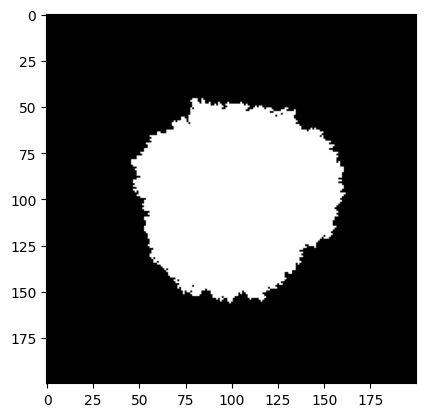

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class FastDLA:
    def __init__(self, L=200):
        self.L = L
        self.grid = np.zeros((L, L), dtype=int)
        self.grid[L//2, L//2] = 1
        self.boundary = {(L//2, L//2)}  # Using a set for faster lookups

    def update_boundary(self):
        new_boundary = set()
        directions = [(0,1), (1,0), (0,-1), (-1,0)]
        for i in range(self.L):
            for j in range(self.L):
                if self.grid[i,j] == 0:
                    for dx, dy in directions:
                        ni, nj = i + dx, j + dy
                        if 0 <= ni < self.L and 0 <= nj < self.L and self.grid[ni, nj] == 1:
                            new_boundary.add((i, j))
        self.boundary = new_boundary

    def run(self, N):
        directions = [(0,1), (1,0), (0,-1), (-1,0)]

        for _ in range(N):
            if not self.boundary:
                self.update_boundary()

            # Choose a random point from the boundary
            x, y = self.boundary.pop()

            # Store the initial boundary point to add back if the point doesn't aggregate
            initial_boundary_point = (x, y)

            while True:
                dx, dy = directions[np.random.randint(0, 4)]

                # Move only if inside the boundaries
                if 0 < x + dx < self.L-1 and 0 < y + dy < self.L-1:
                    x += dx
                    y += dy

                    if self.grid[x, y] == 1:
                        # Aggregate and break
                        self.grid[x - dx, y - dy] = 1

                        # Update the boundary
                        for dx1, dy1 in directions:
                            if 0 <= x + dx1 < self.L and 0 <= y + dy1 < self.L and self.grid[x + dx1, y + dy1] == 0:
                                self.boundary.add((x + dx1, y + dy1))
                        break
                else:
                    # If the walker goes out of bounds, break the loop
                    self.boundary.add(initial_boundary_point)  # Add back the initial boundary point
                    break

    def visualize(self):
        plt.imshow(self.grid, cmap='gray')
        plt.title("")
        plt.show()

# # Example usage:
fast_dla = FastDLA(L=200)
fast_dla.run(10000)
fast_dla.visualize()


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# def box_counting(grid, max_box_size=None, min_box_size=1, threshold=0.5):
#     """Compute the box counting for a given 2D grid."""
#     if max_box_size is None:
#         max_box_size = grid.shape[0] // 2

#     sizes = []
#     counts = []

#     size = max_box_size
#     while size >= min_box_size:
#         count = 0
#         for i in range(0, grid.shape[0], size):
#             for j in range(0, grid.shape[1], size):
#                 fraction_covered = np.sum(grid[i:i+size, j:j+size]) / (size * size)
#                 if fraction_covered > threshold:
#                     count += 1

#         sizes.append(size)
#         counts.append(count)
#         size //= 2

#     return sizes, counts

# def compute_fractal_dimension(grid):
#     """Compute and plot fractal dimension of a 2D grid using the box counting method."""
#     sizes, counts = box_counting(grid)
#     logsizes = np.log(sizes)
#     logcounts = np.log(counts)

#     # Use linear regression to compute the slope, which corresponds to the fractal dimension
#     coeffs = np.polyfit(-logsizes, logcounts, 1)

#     # Plotting
#     plt.figure(figsize=(8,6))
#     plt.scatter(-logsizes, logcounts, color='blue', label='Box Count Data')
#     plt.plot(-logsizes, coeffs[0]*(-logsizes) + coeffs[1], color='red', label=f'Linear Fit (D={coeffs[0]:.2f})')
#     plt.xlabel('log(1/size)')
#     plt.ylabel('log(count)')
#     plt.title('Box Counting Method for Fractal Dimension')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     return coeffs[0]


# The `FractalDimension` class
is designed to compute and visualize the fractal dimension of a given structure represented by a 2D grid. The underlying concept to ascertain the fractal dimension is based on the relationship between the "mass" of an object and the scale at which it's observed.

For conventional Euclidean objects:
- A line, which has a dimension $D = 1$, sees its length $L$ scale as $L^1$.
- A surface, characterized by a dimension $D = 2$, has its area $A$ scaling as $L^2$.
- A volume, having a dimension $D = 3$, observes its volume $V$ scale as $L^3$.

Contrastingly, fractals don't snugly fit these categories. Their dimension is often non-integer, hovering between the dimensions of classic geometric entities. Their relationship can be encapsulated as:
$ M(r) \propto r^D $
Where:
- $M(r)$ represents the "mass" or count of points within a radius $r$ from a reference point.
- $D$ stands for the fractal dimension, a value oscillating between 1 and 2 for our 2D grid.

By applying logarithm to both equation sides, we derive:
$ \log(M(r)) = D \cdot \log(r) + \text{constant} $
This formula describes a straight line in a log-log plot of $M(r)$ against $r$, with the slope revealing the fractal dimension $D$.

To determine the fractal dimension using the `FractalDimension` class:
1. For various radii, we enumerate the "mass" or the occupied cells number within a circle of radius $r$, centralized at the grid's midpoint.
2. Subsequently, we sketch $ \log(M(r)) $ versus $ \log(r) $.
3. A linear fit on this log-log graph yields the slope, indicative of the fractal dimension $D$.

The class's visualization function showcases this log-log plot, accompanied by the inferred fractal dimension.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class FractalDimension:

    def __init__(self, grid, fit_radius=20):
        self.grid = grid
        self.L = grid.shape[0]
        self.center = self.L // 2
        self.fit_radius = fit_radius

    def mass_inside_radius(self, r):
        """
        Count the number of occupied cells within a given radius.
        """
        x, y = np.ogrid[-self.center:self.L-self.center, -self.center:self.L-self.center]
        mask = x*x + y*y <= r*r
        return np.sum(self.grid[mask])

    def compute_fractal_dimension(self, max_radius=None):
        """
        Compute the fractal dimension of the configuration.
        """
        if not max_radius:
            max_radius = self.L // 2

        radii = np.arange(1, max_radius)
        masses = np.array([self.mass_inside_radius(r) for r in radii])

        # Ensuring we're not taking the logarithm of zero
        valid = masses > 0
        radii = radii[valid]
        masses = masses[valid]

        # Filtering the data for the fit within the specified radius
        fit_mask = radii <= self.fit_radius
        fit_radii = radii[fit_mask]
        fit_masses = masses[fit_mask]

        # Log-log plot
        log_fit_radii = np.log(fit_radii)
        log_fit_masses = np.log(fit_masses)

        slope, _ = np.polyfit(log_fit_radii, log_fit_masses, 1)
        return slope, radii, masses

    def visualize(self):
        """
        Plot the data on a log-log scale with a linear fit.
        """
        D, radii, masses = self.compute_fractal_dimension()

        plt.figure(figsize=(10,7))
        plt.loglog(radii, masses, 'o', label=f"Measured Data")

        # Adjusting the linear fit to pass through the first data point
        log_radii = np.log(radii)
        log_masses = D * (log_radii - log_radii[0]) + np.log(masses[0])  # Adjusted linear fit
        plt.loglog(radii, np.exp(log_masses), 'r', label=f"Linear Fit: Fractal Dimension = {D:.2f}")

        plt.xlabel("Log(Radius)")
        plt.ylabel("Log(Mass)")
        plt.title("Log-Log plot of Mass vs. Radius")
        plt.legend()
        plt.grid(True, which="both", ls="--", c='0.65')
        plt.show()


# Usage:
# Assuming 'grid' is the name of the 2D numpy array from the DLA simulation
# fd = FractalDimension(grid)
# fd.visualize()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class StochasticDLA:
    def __init__(self, L=200, acceptance_probability=1.0):
        self.L = L
        self.grid = np.zeros((L, L), dtype=int)
        self.grid[L//2, L//2] = 1
        self.P = acceptance_probability

        # Using sets for efficient look-up
        self.aggregates = set([(L//2, L//2)])
        self.boundary = set([(L//2 + dx, L//2 + dy) for dx, dy in [(0,1), (1,0), (0,-1), (-1,0)]])

    def get_starting_radius(self, buffer=20):
        max_dist = max(np.sqrt((x-self.L//2)**2 + (y-self.L//2)**2) for x, y in self.boundary)
        return int(max_dist + buffer)

    def run(self, N, snapshot_intervals):
        directions = [(0,1), (1,0), (0,-1), (-1,0)]
        snapshots = []

        while len(self.aggregates) < N:
            r = self.get_starting_radius()
            theta = 2 * np.pi * np.random.random()
            x, y = int(self.L//2 + r * np.cos(theta)), int(self.L//2 + r * np.sin(theta))
            walker_position = (x, y)

            while True:
                dx, dy = directions[np.random.randint(0, 4)]

                # Check boundaries
                if 0 < x + dx < self.L and 0 < y + dy < self.L:
                    x += dx
                    y += dy
                    walker_position = (x, y)

                    # If walker is on boundary and it is an empty site
                    if walker_position in self.boundary and walker_position not in self.aggregates:
                        if np.random.random() < self.P:
                            # Update aggregates and boundary
                            self.aggregates.add(walker_position)
                            self.grid[x, y] = 1

                            # Remove current position from boundary and add neighbors to boundary
                            self.boundary.remove(walker_position)
                            for dx, dy in directions:
                                neighbor = (x + dx, y + dy)
                                if 0 < neighbor[0] < self.L and 0 < neighbor[1] < self.L and neighbor not in self.aggregates:
                                    self.boundary.add(neighbor)
                            break

            # Take snapshots at specified intervals
            if len(self.aggregates) in snapshot_intervals:
                snapshots.append(self.grid.copy())

        return snapshots

    def visualize(self, snapshots):
        fig, axes = plt.subplots(1, len(snapshots), figsize=(15, 5))
        for ax, snapshot in zip(axes, snapshots):
            ax.imshow(snapshot, cmap='gray')
            ax.set_title(f"Aggregates: {np.sum(snapshot)}")
            ax.axis('off')
        plt.tight_layout()
        plt.show()

# # Example usage:
# dla = StochasticDLA(L=200, acceptance_probability=0.2)
# snapshots = dla.run(1000, [100, 200, 400, 600, 800])
# dla.visualize(snapshots)


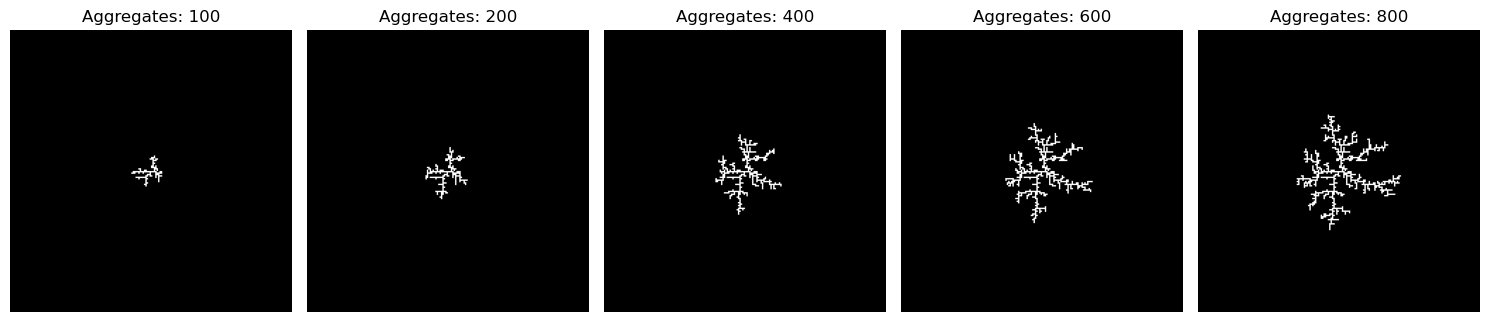

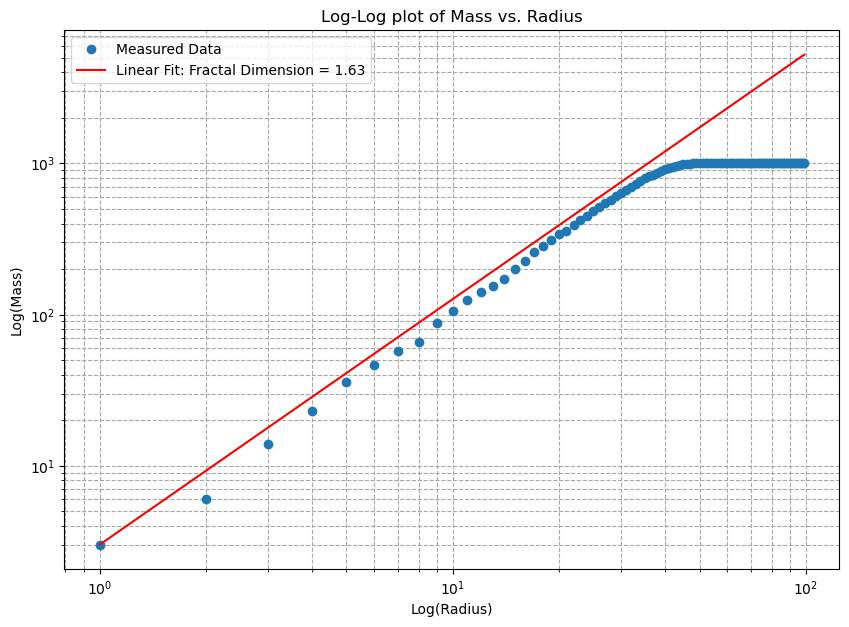

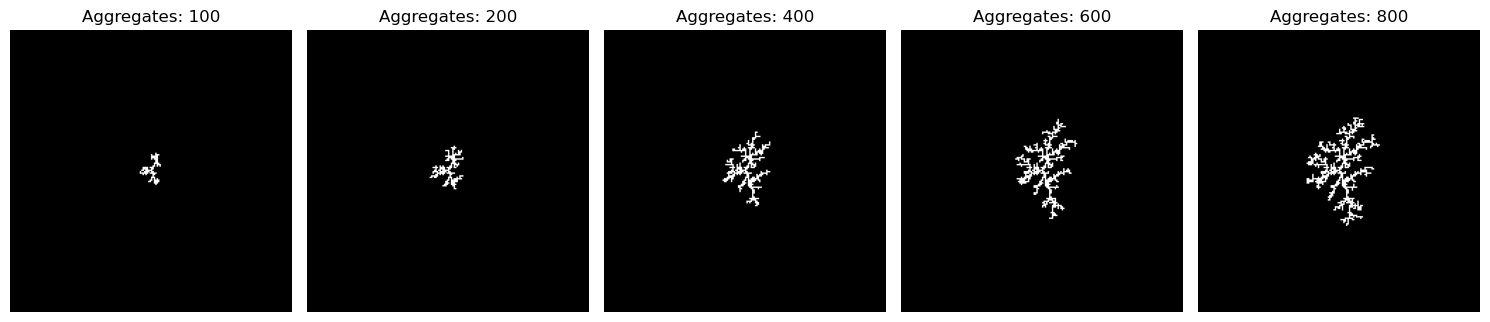

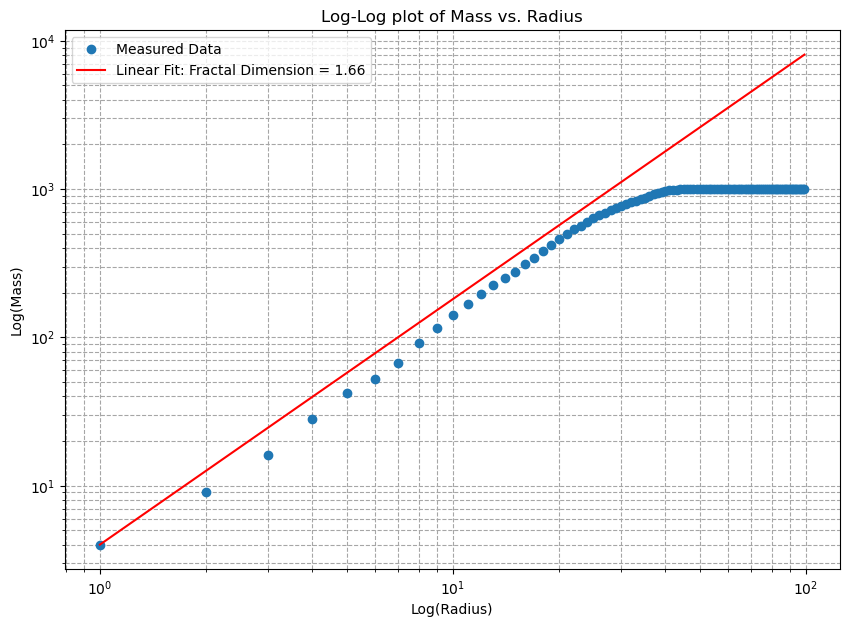

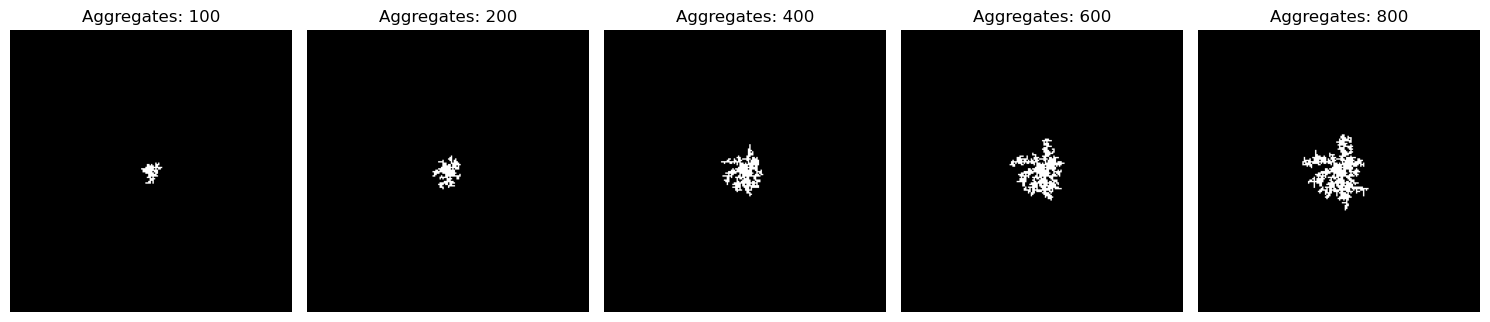

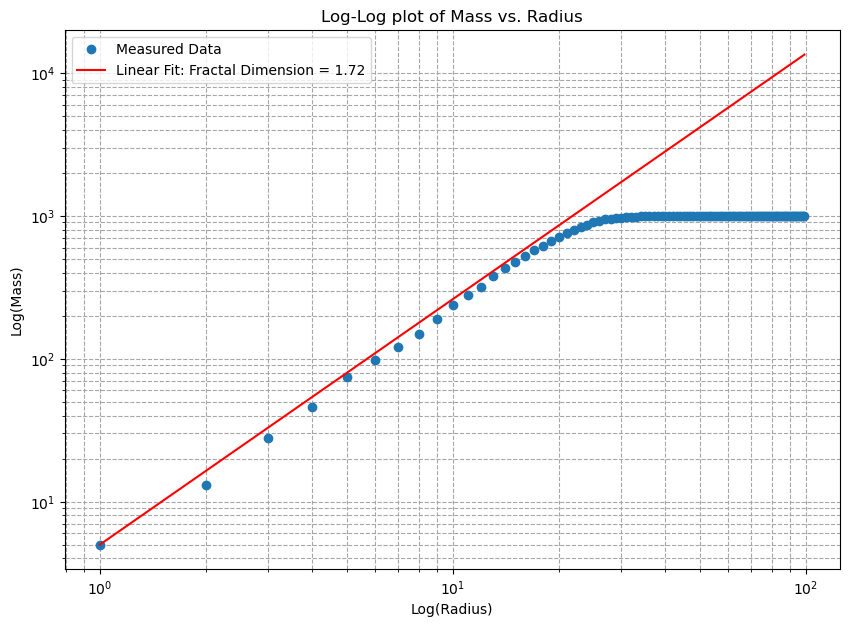

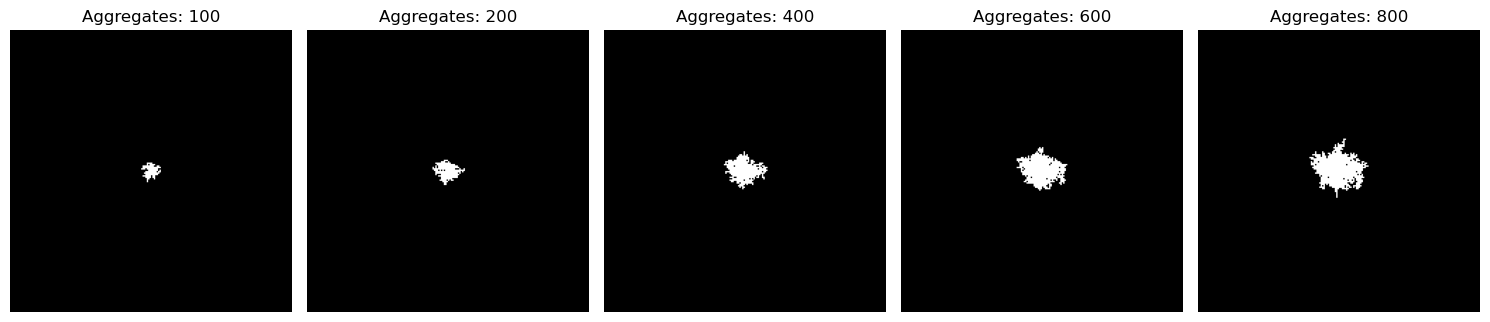

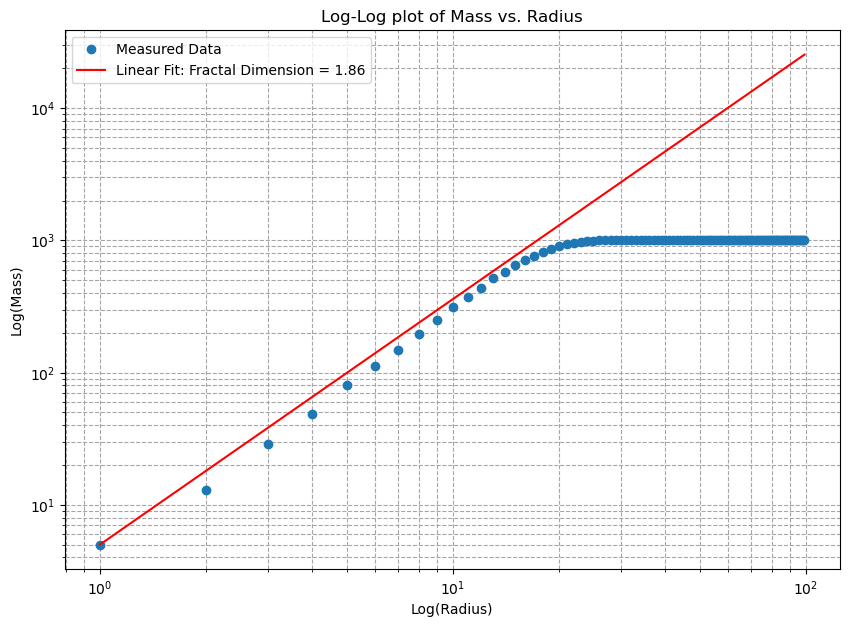

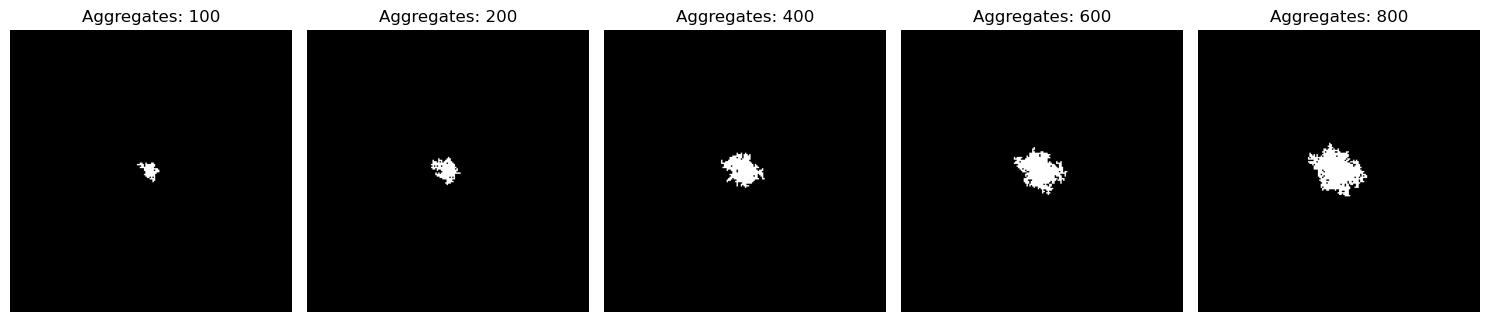

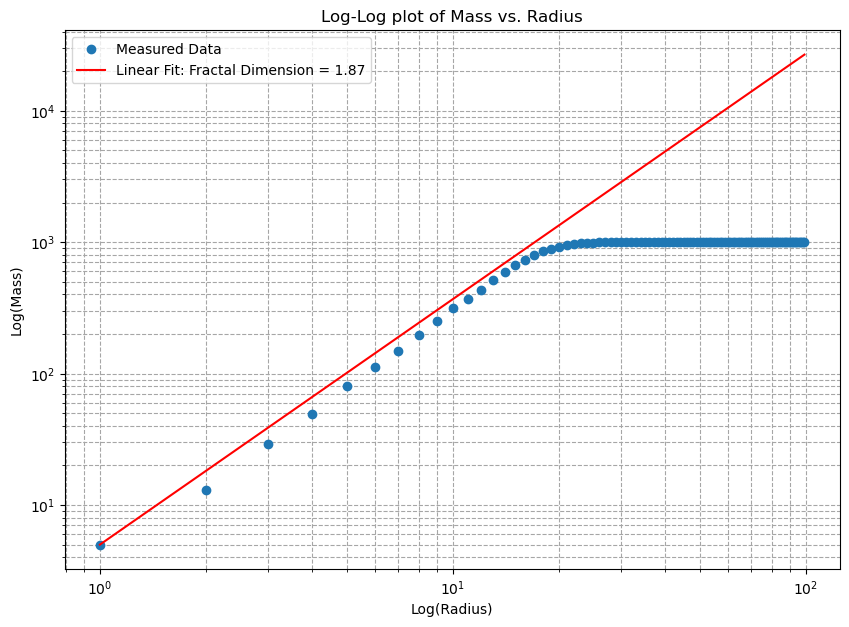

In [ ]:
for p in [1., 0.4, 0.1, 0.02, 0.005]:
    dla = StochasticDLA(L=200, acceptance_probability=p)
    snapshots = dla.run(1000, [100, 200, 400, 600, 800])
    dla.visualize(snapshots)
    fd = FractalDimension(dla.grid,fit_radius=18)
    fd.visualize()


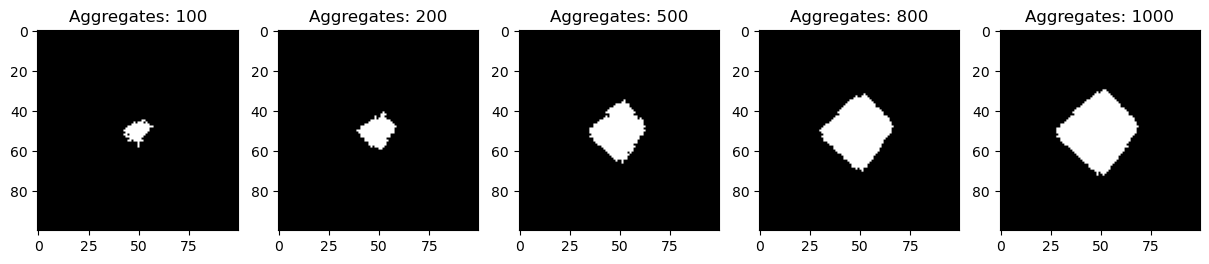

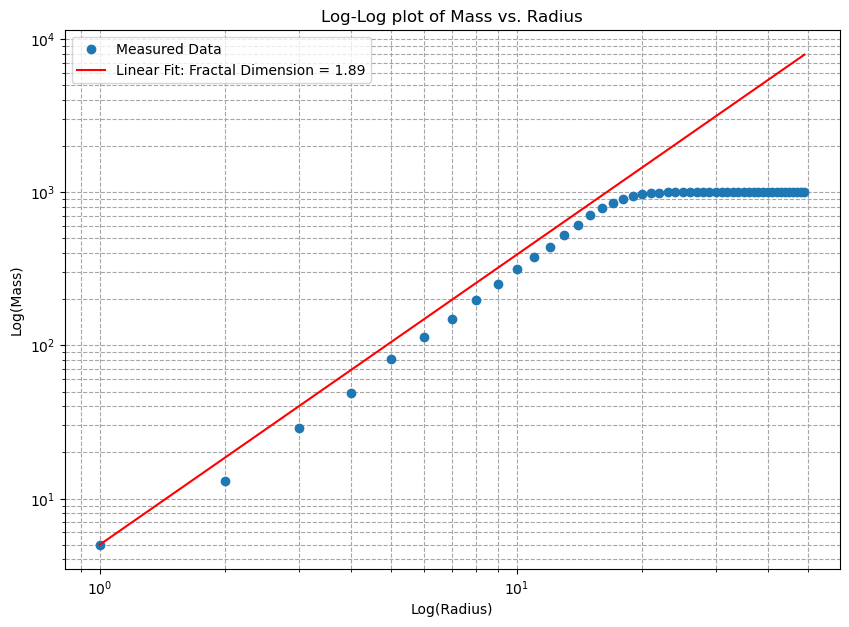

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class EdenModel:
    def __init__(self, L=200):
        self.L = L
        self.grid = np.zeros((L, L), dtype=int)
        self.grid[L//2, L//2] = 1

        # Using sets for efficient look-up
        self.aggregates = set([(L//2, L//2)])
        self.boundary = set([(L//2 + dx, L//2 + dy) for dx, dy in [(0,1), (1,0), (0,-1), (-1,0)]])

        self.snapshots = []  # To store the intermediate states

    def run(self, N, snapshot_intervals):
        directions = [(0,1), (1,0), (0,-1), (-1,0)]

        next_snapshot = 0
        while len(self.aggregates) < N:
            x, y = self.boundary.pop()

            self.aggregates.add((x, y))
            self.grid[x, y] = 1

            for dx, dy in directions:
                neighbor = (x + dx, y + dy)
                if 0 <= neighbor[0] < self.L and 0 <= neighbor[1] < self.L and neighbor not in self.aggregates:
                    self.boundary.add(neighbor)

            # Save snapshots at specified intervals
            if len(self.aggregates) >= snapshot_intervals[next_snapshot]:
                self.snapshots.append(self.grid.copy())
                next_snapshot += 1
                if next_snapshot >= len(snapshot_intervals):
                    break

    def visualize(self, snapshots=True):
        if snapshots:
            fig, axes = plt.subplots(1, len(self.snapshots), figsize=(15, 5))
            for ax, grid_snapshot in zip(axes, self.snapshots):
                ax.imshow(grid_snapshot, cmap='gray')
                ax.set_title(f"Aggregates: {np.sum(grid_snapshot)}")
        else:
            plt.imshow(self.grid, cmap='gray')
            plt.title("Eden Growth with %d aggregates" % len(self.aggregates))
            plt.show()

# Example usage:
eden = EdenModel(L=100)
snapshot_intervals = [100, 200, 500, 800, 1000]
eden.run(1000, snapshot_intervals)
eden.visualize()
fd = FractalDimension(eden.grid,fit_radius=16)
fd.visualize()